In [14]:
import time
import numpy as np
import pandas as pd
import seaborn as sb
from IPython.display import display, clear_output 
from sklearn.metrics import classification_report, mean_squared_error
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 9)

# set random seed to achieve same results each time
np.random.seed(23)

### Loading the Data

In [2]:
train_csv = pd.read_csv("training.csv")
test_csv = pd.read_csv("test.csv")
sample_csv = pd.read_csv("SampleSubmission.csv")
ID_csv = pd.read_csv("IdLookupTable.csv")

### Splitting Training Data into Labels and Data

In [3]:
def create_training(train_csv):
    label_names = train_csv.columns.tolist()[:-1]
    labels = train_csv.loc[:, train_csv.columns != 'Image'].values

    data = train_csv['Image'].str.split()
    data = np.vstack(data.apply(lambda row: np.asarray([int(n) for n in row])).values)
    data = data/255.0 # Rescale grayscale values to [0,1].
    
    # Shuffle the data
    shuffle = np.random.permutation(np.arange(data.shape[0]))
    data, labels = data[shuffle], labels[shuffle]
    
    # Splitting into dev and training
    dev_data, dev_labels = data[:1000], labels[:1000]
    train_data, train_labels = data[1000:], labels[1000:]
    
    return dev_data, dev_labels, train_data, train_labels, label_names

In [4]:
dev_data, dev_labels, train_data, train_labels, label_names = create_training(train_csv)

### Plotting an Example

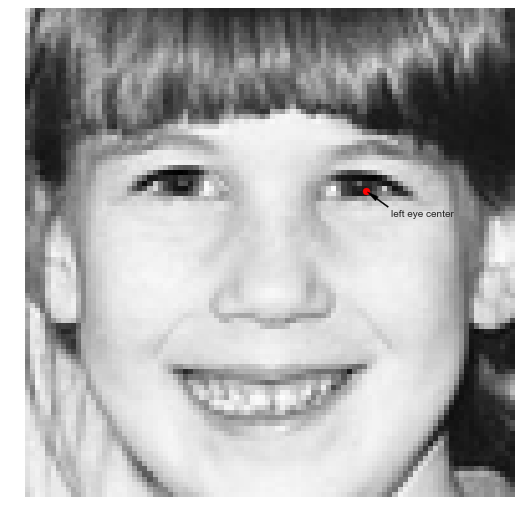

In [5]:
def plot_example(image_number):
    plt.imshow(dev_data[image_number].reshape(96, 96), cmap='gray')
    plt.axis('off')
    plt.scatter(dev_labels[image_number][0], dev_labels[image_number][1], c='red', marker='o')
    
    plt.annotate('left eye center', xy         = (dev_labels[image_number][0], 
                                                  dev_labels[image_number][1]), 
                                    xytext     = (dev_labels[image_number][0]+5, 
                                                  dev_labels[image_number][1]+5),
                                    arrowprops = {'facecolor': 'black', 'shrink': 0.05, 
                                                  'width':1.2, 'headwidth': 5})
    return

plot_example(5)

### Simple Classifers

We note that there are a ton of missing labels. Below is the percentage of labels for each Facial Keypoint in the training data set

In [6]:
(train_csv.loc[:, train_csv.columns != 'Image'].count()/len(train_csv.index)).round(3)

left_eye_center_x            0.999
left_eye_center_y            0.999
right_eye_center_x           0.998
right_eye_center_y           0.998
left_eye_inner_corner_x      0.322
left_eye_inner_corner_y      0.322
left_eye_outer_corner_x      0.322
left_eye_outer_corner_y      0.322
right_eye_inner_corner_x     0.322
right_eye_inner_corner_y     0.322
right_eye_outer_corner_x     0.322
right_eye_outer_corner_y     0.322
left_eyebrow_inner_end_x     0.322
left_eyebrow_inner_end_y     0.322
left_eyebrow_outer_end_x     0.316
left_eyebrow_outer_end_y     0.316
right_eyebrow_inner_end_x    0.322
right_eyebrow_inner_end_y    0.322
right_eyebrow_outer_end_x    0.317
right_eyebrow_outer_end_y    0.317
nose_tip_x                   1.000
nose_tip_y                   1.000
mouth_left_corner_x          0.322
mouth_left_corner_y          0.322
mouth_right_corner_x         0.322
mouth_right_corner_y         0.322
mouth_center_top_lip_x       0.323
mouth_center_top_lip_y       0.323
mouth_center_bottom_

We will attempt to fit simple classifers to the labels of the Facial Keypoints with the highest amount of non-missing labels: 
- left_eye_center 
- right_eye_center 
- nose_tip 
- mouth_center_bottom_lip

#### Left Eye Center

Let's examine some summary statistics of this feature

In [7]:
left_eye_center_x, left_eye_center_y = train_labels[:, 0], train_labels[:, 1]

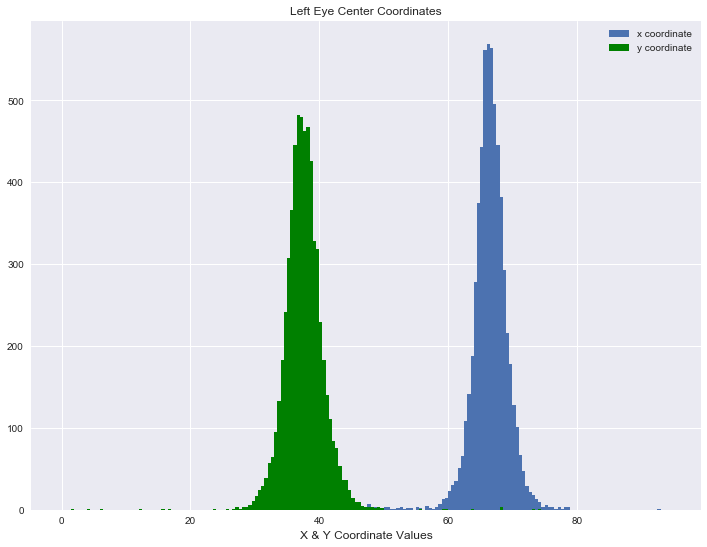

In [8]:
plt.hist(left_eye_center_x[np.isfinite(left_eye_center_x)], bins=np.arange(35, 95, 0.5), label = 'x coordinate');
plt.hist(left_eye_center_y[np.isfinite(left_eye_center_y)], bins=np.arange(0, 85, 0.5),  label = 'y coordinate',
         color='green');
plt.title('Left Eye Center Coordinates', fontsize=12)
plt.xlabel('X & Y Coordinate Values',    fontsize=12)
plt.legend()

#### x-cordinate of left eye

Since our coordinate values of our labels are continuous, we will use K-NN Regression

In [42]:
k_nn_xcoord = KNeighborsRegressor(radius=1)

In [43]:
k_nn_xcoord.fit(train_data[np.isfinite(train_labels[:, 0])], 
                train_labels[:, 0][np.isfinite(train_labels[:, 0])])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [12]:
x_pred = k_nn_xcoord.predict(dev_data[np.isfinite(dev_labels[:, 0])])

In [23]:
np.sqrt(mean_squared_error(dev_labels[:, 0][np.isfinite(dev_labels[:, 0])], 
                           x_pred))

3.0483511829725214

#### y-cordinate of left eye

In [44]:
k_nn_ycoord = KNeighborsRegressor(radius=1)

In [45]:
k_nn_ycoord.fit(train_data[np.isfinite(train_labels[:, 1])], 
         train_labels[:, 1][np.isfinite(train_labels[:, 1])])

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='uniform')

In [27]:
y_pred = k_nn_ycoord.predict(dev_data[np.isfinite(dev_labels[:, 1])])

In [28]:
np.sqrt(mean_squared_error(dev_labels[:, 1][np.isfinite(dev_labels[:, 1])], 
                           y_pred))

3.0730939040764014

#### Visualizing Result

In [46]:
x = k_nn_xcoord.predict(dev_data[0].reshape(1, -1))
y = k_nn_ycoord.predict(dev_data[0].reshape(1, -1))

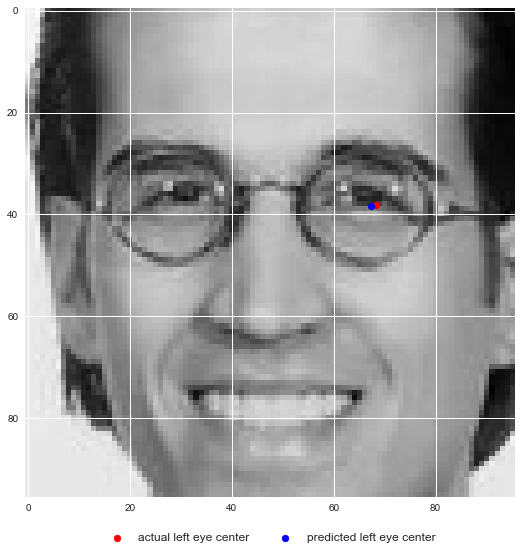

In [50]:
plt.imshow(dev_data[0].reshape(96,96), cmap='gray')
plt.scatter(dev_labels[0,0], dev_labels[0,1], color='red', label='actual left eye center')
plt.scatter(x, y, color='blue', label='predicted left eye center')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
           fancybox=True,      shadow=True, ncol=2, fontsize=12)